# Fun with Maps

Display random locations on a map and try to find funny shapes in them.

## Dependencies

In [ ]:
using System.Net.Http;
using System.Globalization;
using System.IO;

using static Microsoft.DotNet.Interactive.Formatting.PocketViewTags;

var random = new Random();
var httpClient = new HttpClient();

## Step 1: Get images from map locations

The project will be using using [Azure Maps](https://docs.microsoft.com/en-us/azure/azure-maps/) to retrieve the map images. Images will be stored in the `output/step1` folder.

### Configuration

Create an [Azure Maps account](https://docs.microsoft.com/en-us/azure/azure-maps/quick-demo-map-app#create-an-azure-maps-account) and get the primary key for that account.

In [ ]:
var azureMapsSubscriptionKey = "<your-subscription-key>";

### Pick random locations

Select a random zoom level and a random location ([As per documentation](https://docs.microsoft.com/en-us/rest/api/maps/render/get-map-image))

* _Zoom level_ ranges from 0 to 20.
* _Longitude_ range: -180 to 180.
* _Latitude_ range: -85 to 85.

In [ ]:
// actual ranges are slightly different from documentation, to get more interesting results
var zoomLevelRange = 5..13;
var longitudeRange = 0..180;
var latitudeRange = 0..75;

In [ ]:
var numberOfImages = 8;

var imageLocations = Enumerable.Range(0, numberOfImages)
	.Select(i => new
	{
		ZoomLevel = random.Next(zoomLevelRange.Start.Value, zoomLevelRange.End.Value),
		Longitude = random.NextDouble() * (2 * longitudeRange.End.Value) - longitudeRange.End.Value,
		Latitude = random.NextDouble() * (2 * latitudeRange.End.Value) - latitudeRange.End.Value,
	})
	.ToArray();
display(imageLocations);

index,ZoomLevel,Longitude,Latitude
0,6,19.178513153646065,3.5665496230785436
1,5,66.94886706256165,28.992473558534343
2,5,-84.57168856467784,-13.458943428728013
3,9,-89.47900045136153,-53.88430794224408
4,6,21.241918901044727,-52.77084288604283
5,12,-115.45882738516465,48.815487217210546
6,12,-130.0607234246378,-11.460350855754633
7,9,-134.16194753019525,18.97229119993331


### Build the map API calls

In [ ]:
var cultureInfo = CultureInfo.InvariantCulture;

var baseUri = "https://atlas.microsoft.com/map/static/png";
var queryParameters = new Dictionary<string, string>
{
	{ "subscription-key", azureMapsSubscriptionKey },
	{ "api-version", "1.0" },
	{ "width", "256" },
	{ "height", "256" },
};

var imageUriList = imageLocations
	.Select(location => {
		queryParameters["center"] = $"{location.Longitude.ToString(cultureInfo)},{location.Latitude.ToString(cultureInfo)}";
		queryParameters["zoom"] = $"{location.ZoomLevel}";

		return new Uri(baseUri + "?" + string.Join("&", queryParameters.Select(kvp => $"{kvp.Key}={kvp.Value}")));
	})
	.ToArray();

display(imageUriList.Select(uri => uri.ToString().Replace(azureMapsSubscriptionKey, "<OBFUSCATED>")));


index,value
0,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=19.178513153646065,3.5665496230785436&zoom=6"
1,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=66.94886706256165,28.992473558534343&zoom=5"
2,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=-84.57168856467784,-13.458943428728013&zoom=5"
3,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=-89.47900045136153,-53.88430794224408&zoom=9"
4,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=21.241918901044727,-52.77084288604283&zoom=6"
5,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=-115.45882738516465,48.815487217210546&zoom=12"
6,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=-130.0607234246378,-11.460350855754633&zoom=12"
7,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=-134.16194753019525,18.97229119993331&zoom=9"


### Fetch images

In [ ]:
var imageFetchingTasks = imageUriList.Select(uri => 
	httpClient.GetAsync(uri).ContinueWith(task => task.Result.Content.ReadAsByteArrayAsync()));
var imageTaskResults = await Task.WhenAll(imageFetchingTasks);

var images = imageTaskResults.Select(result => result.Result).ToArray();


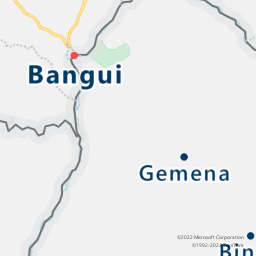
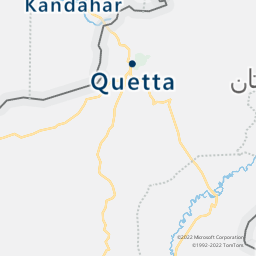
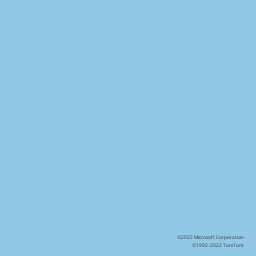
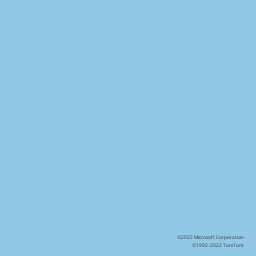
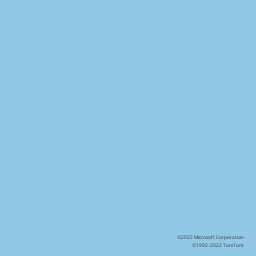
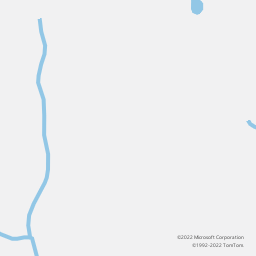
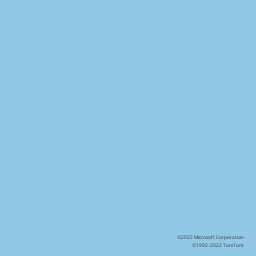
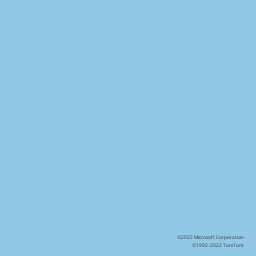

In [ ]:
display(
	HTML(
		string.Join("&nbsp; ", images.Select(image => 
			span(
				img[src: "data:image/png;base64," + Convert.ToBase64String(image)]
			)))
	)
);

## Store images on disk

In [ ]:
var imageFolder = "output/step1";

var imageFileNames = imageLocations
	.Select(location => $"{imageFolder}/{location.ZoomLevel}__{location.Longitude.ToString(cultureInfo)}__{location.Latitude.ToString(cultureInfo)}.png");

imageFileNames
	.Zip(images, (fileName, image) => new { 
		FileName = fileName,
		Image = image
	})
	.ToList()
	.ForEach(image => File.WriteAllBytes(image.FileName, image.Image));